# *klustr* by Lamtharn (Hanoi) Hantrakul & Avneesh Sarwate
This notebook is intended to be the one-stop-shop for our Final project for MIR Fall 2017. 

In [3]:
# Imports
%matplotlib inline
from os.path import join
from matplotlib import pyplot as plt
from skimage.measure import block_reduce
from multiprocessing import Pool
import numpy as np
import librosa
from tqdm import tqdm

from time import time
import matplotlib.cm as cm
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_samples, silhouette_score

# Loading the sample library

Our sample dataset consists of ~10,000 drum hits. We have trimmed only the first 0.25s of the drum sounds to preserve the attack portion of the drum shots, while keeping the file size computationally manageable. All drum samples are saved as `.npy` files in `./drumData`. To see how we recursively went through directories and scraped the sample type from the file name see "Samples to Arrays notebook"

In [5]:
data_root = 'drumData'
drumNames = ["kick", "tom", "snare", "clap", "hi.hat", "ride", "crash"]
drumSamples = {}
for d in drumNames:
    drumSamples[d] = np.load(join(data_root, d+'_samples.npy'))

Let's have a look at some of our samples

In [82]:
def plotDrumSamples(drum_dict, drum_name, color):
    # Print the dimensions of the sample set
    print(drum_name, drum_dict[drum_name].shape)
    
    # Plot the the first 5 drum samples
    f, ax = plt.subplots(1, 5, sharey=True, figsize=(50, 10))
    for i, axis in enumerate(ax):
        axis.plot(drum_dict[drum_name][i], c=color)
        if i == 0:
            axis.set_title(drum_name + "\n", fontsize=50)

In [83]:
# Define the mapping of samples to colors used throughout the rest of the project 
colors = ['#000000', '#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '#00ffff']

('kick', (5158, 12000))
('tom', (422, 12000))
('snare', (2546, 12000))
('clap', (1324, 12000))
('hi.hat', (159, 12000))
('ride', (228, 12000))
('crash', (723, 12000))


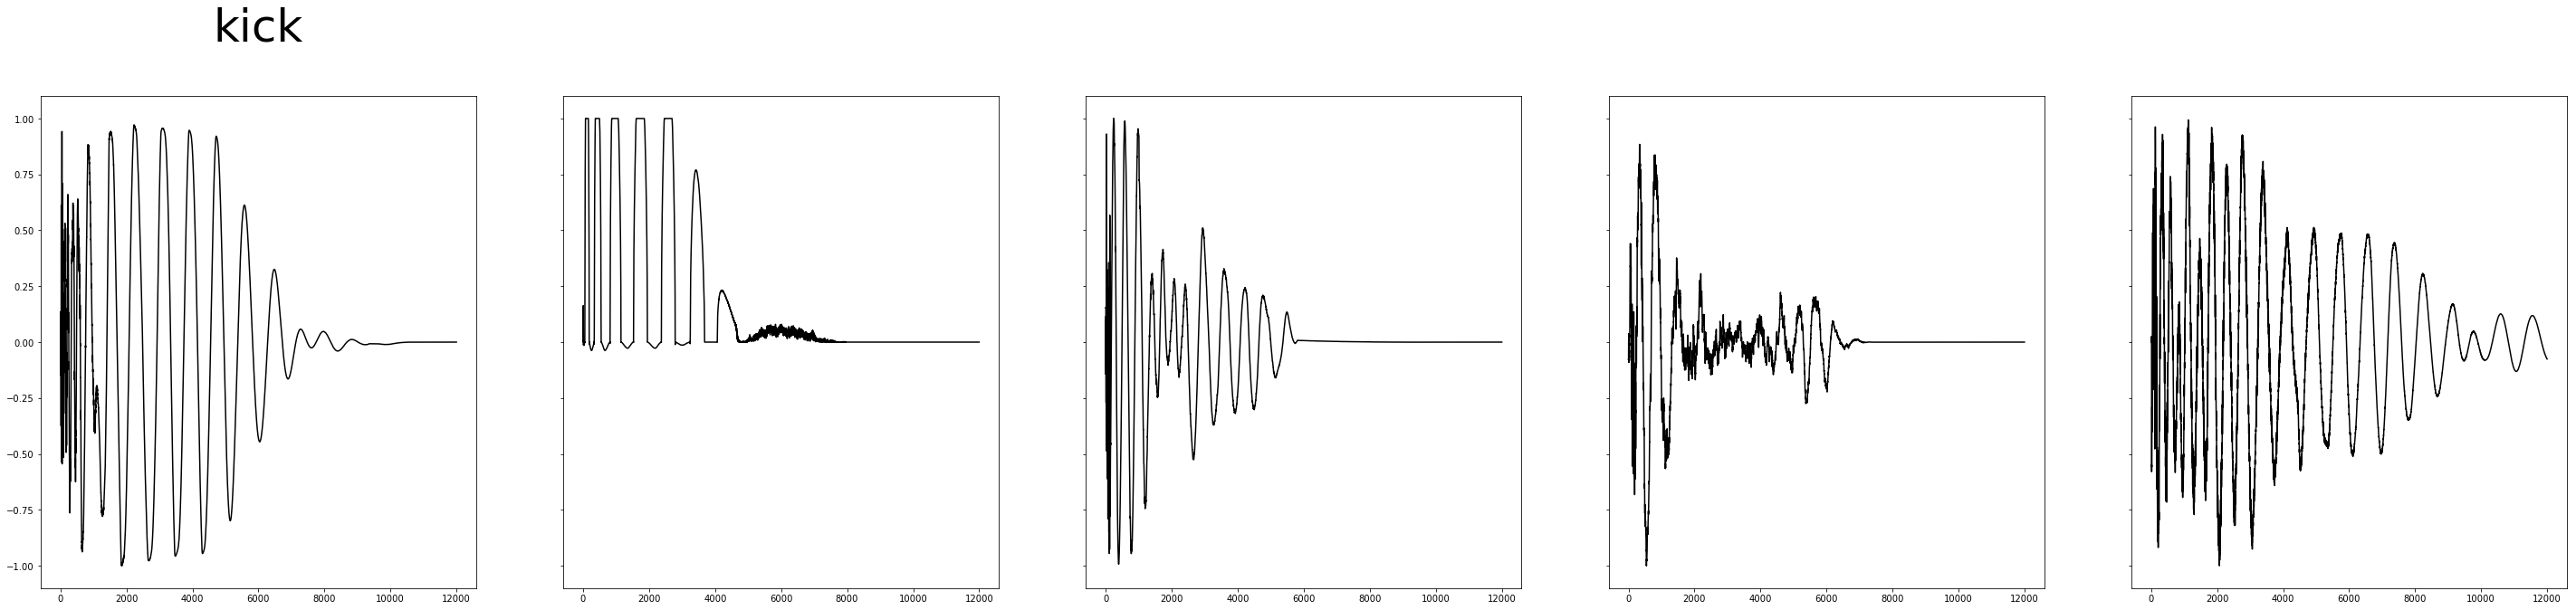

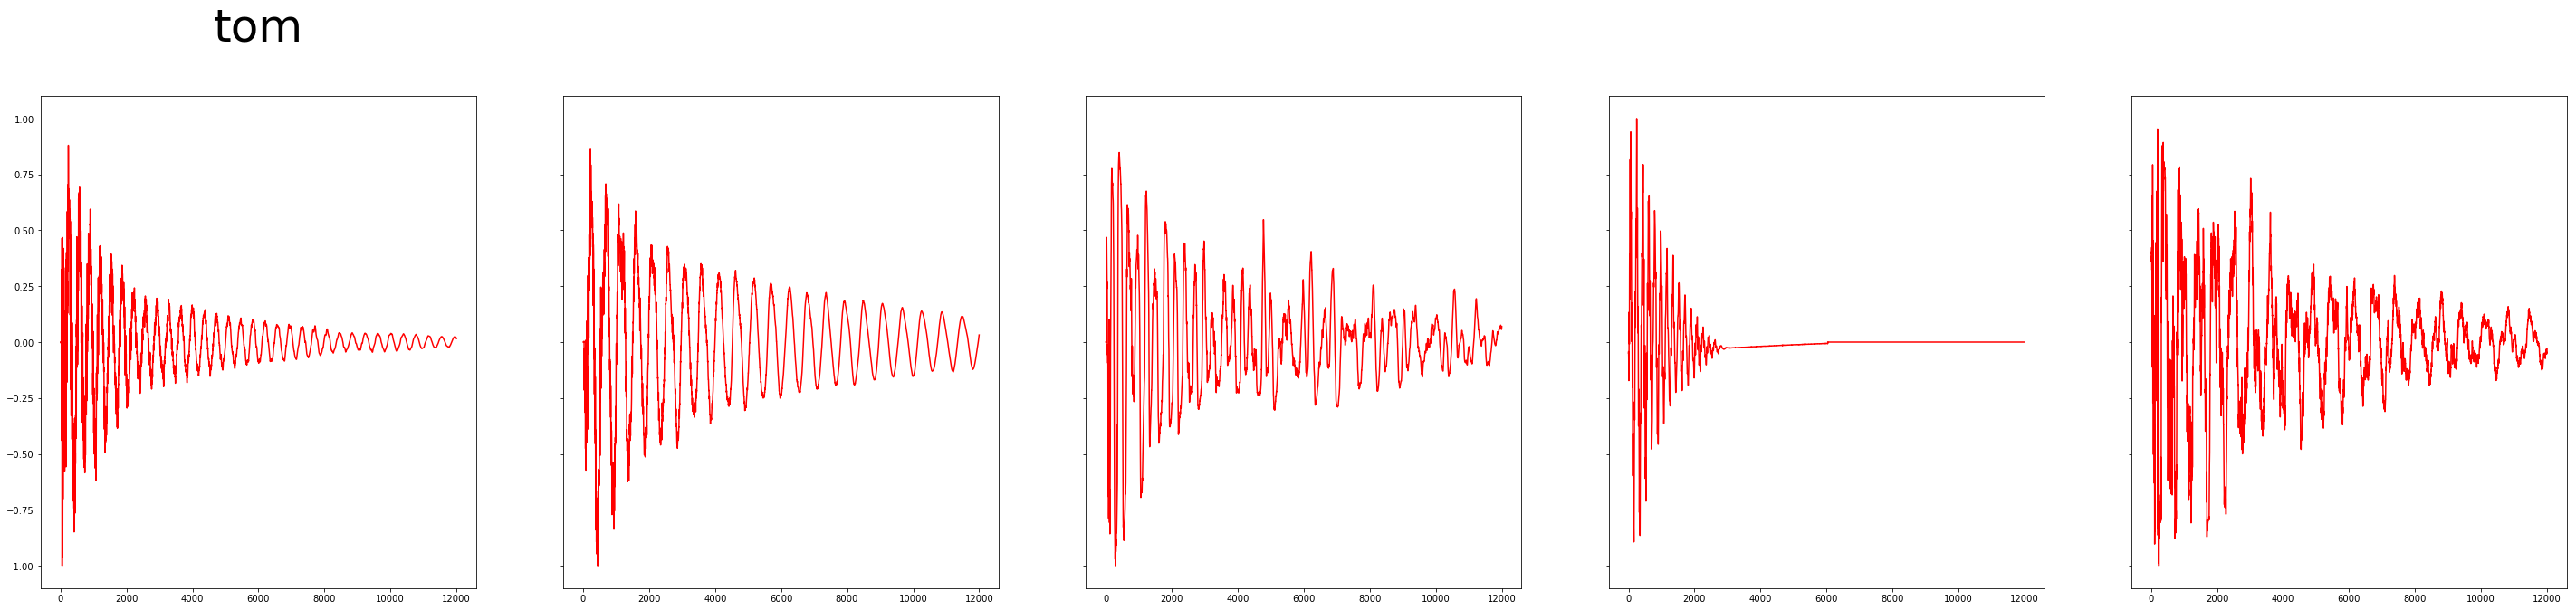

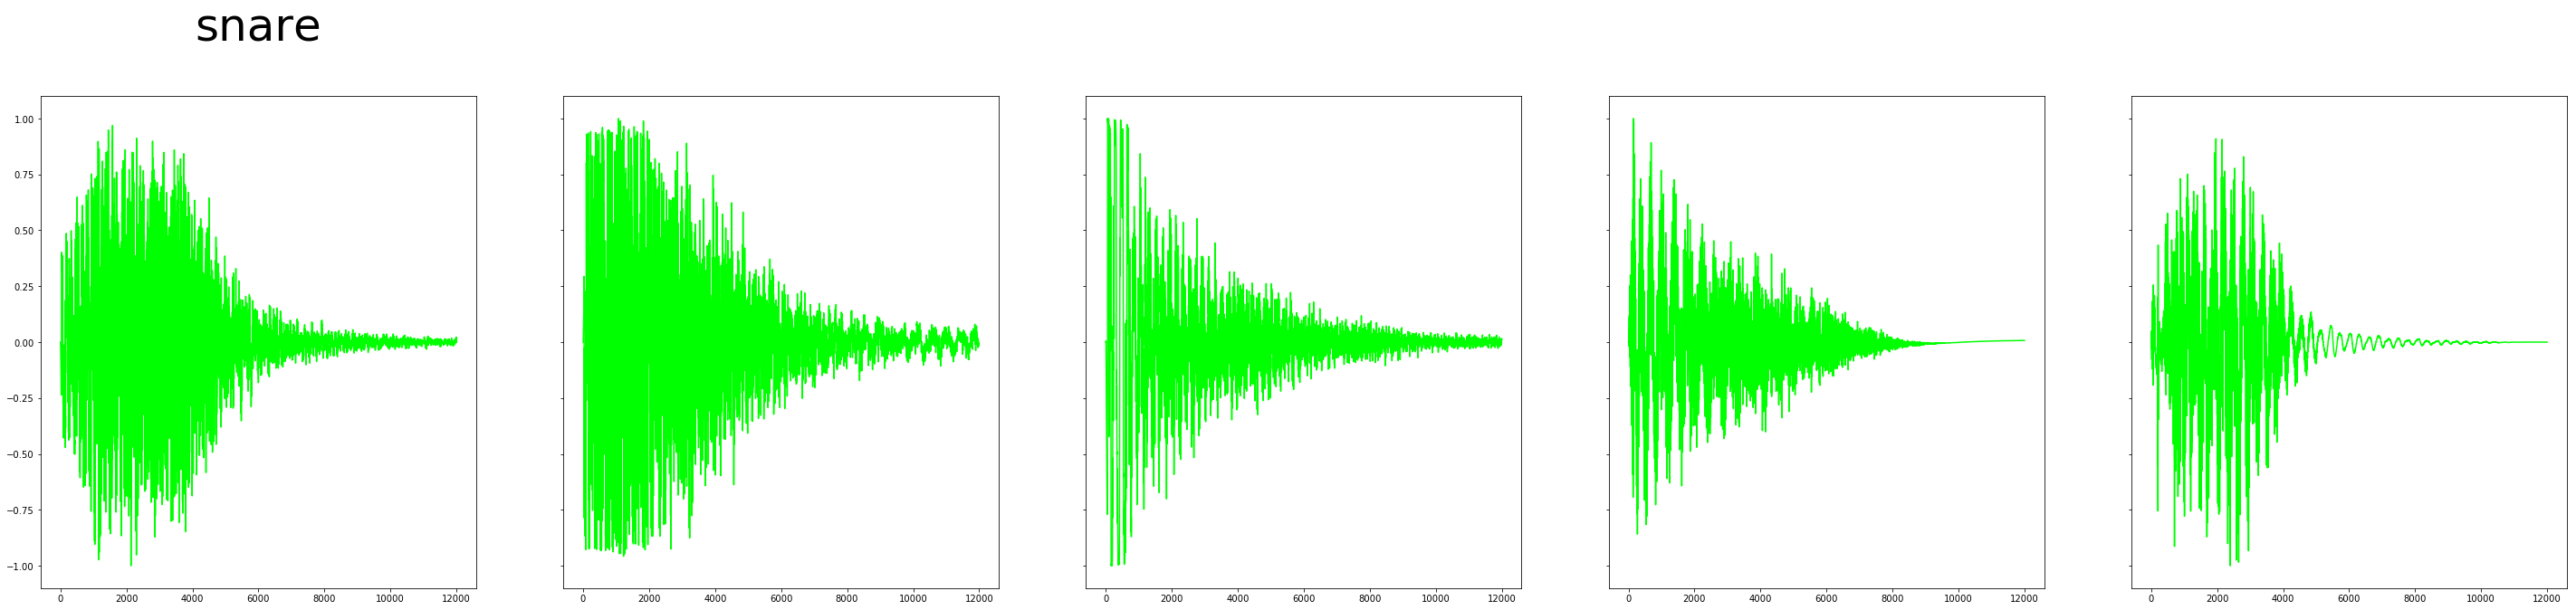

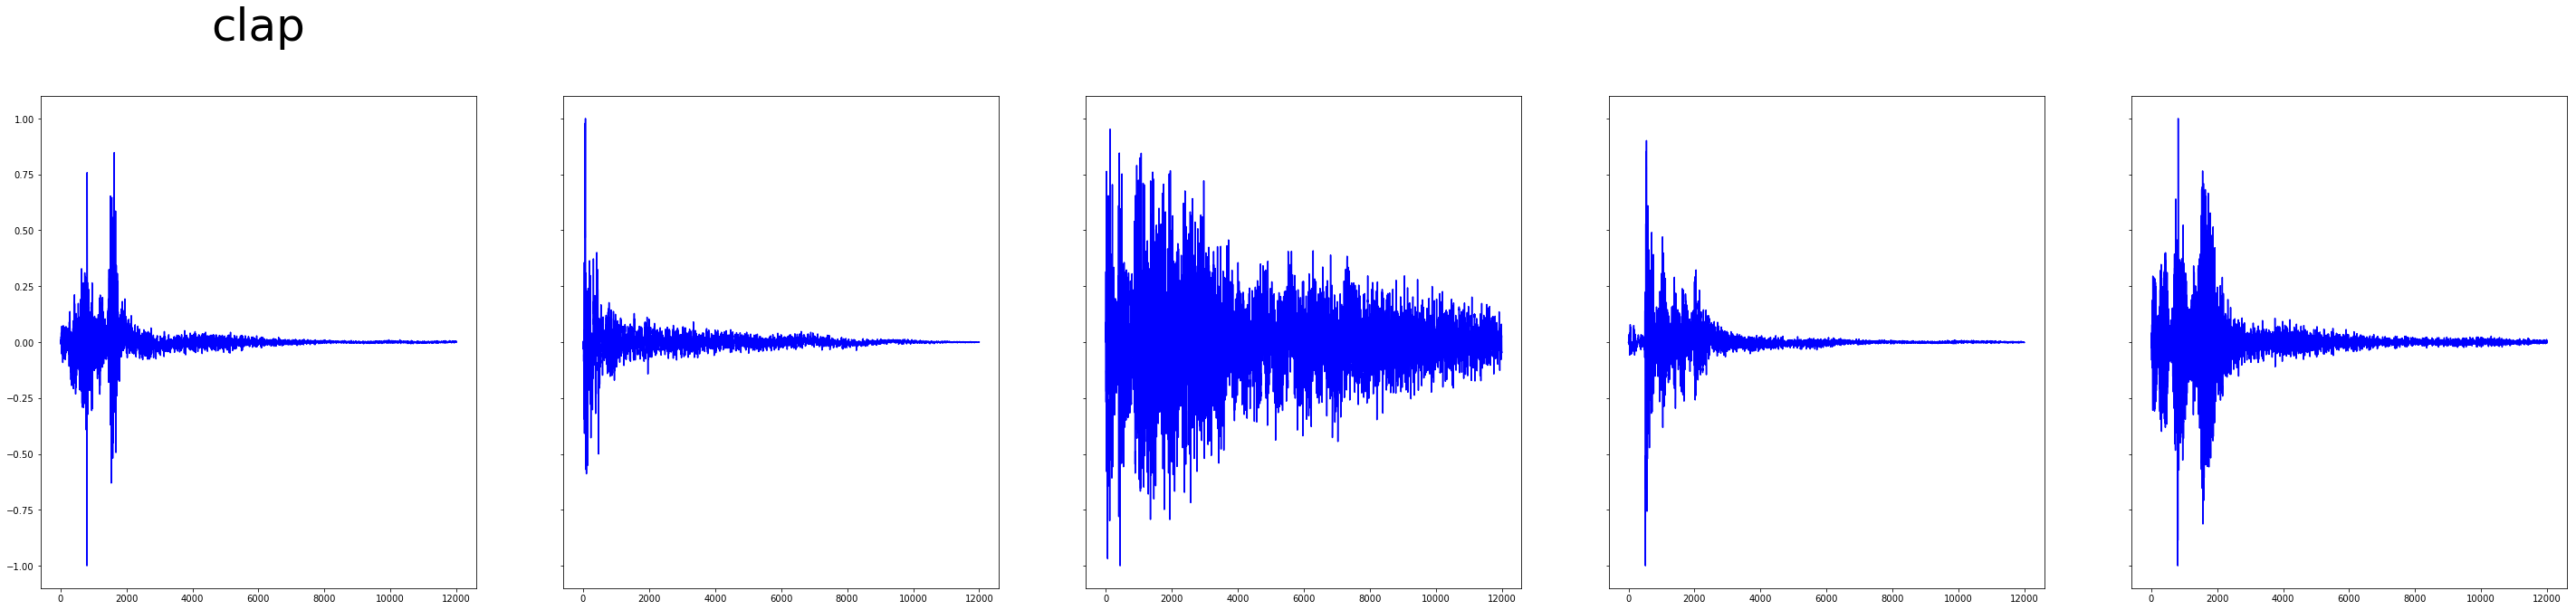

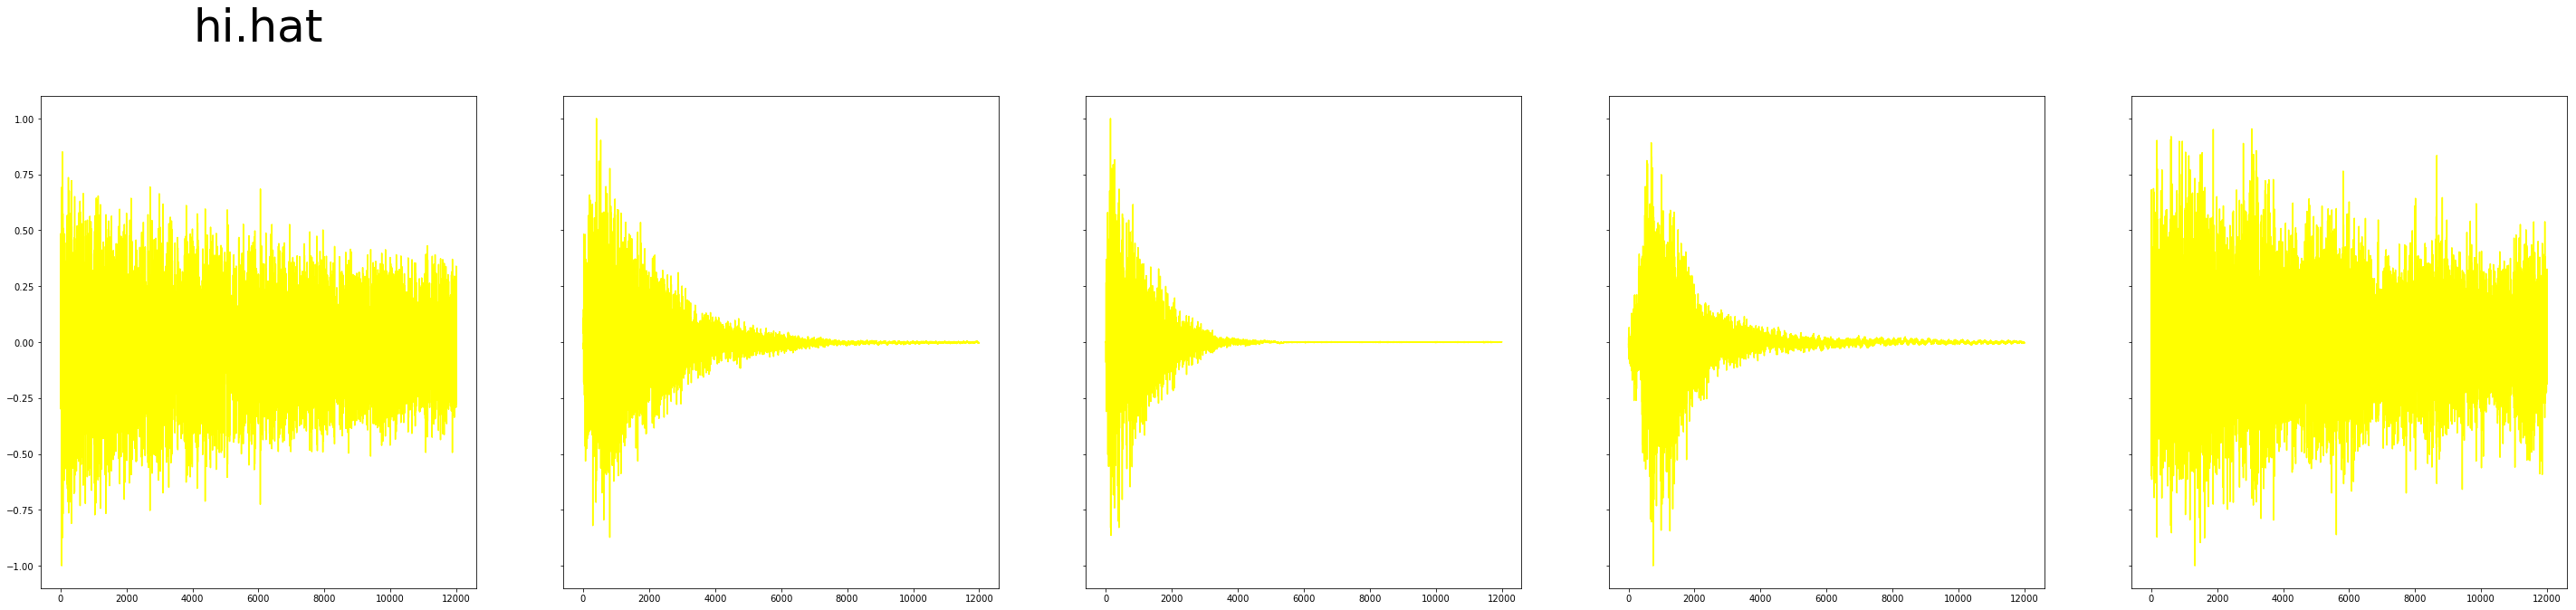

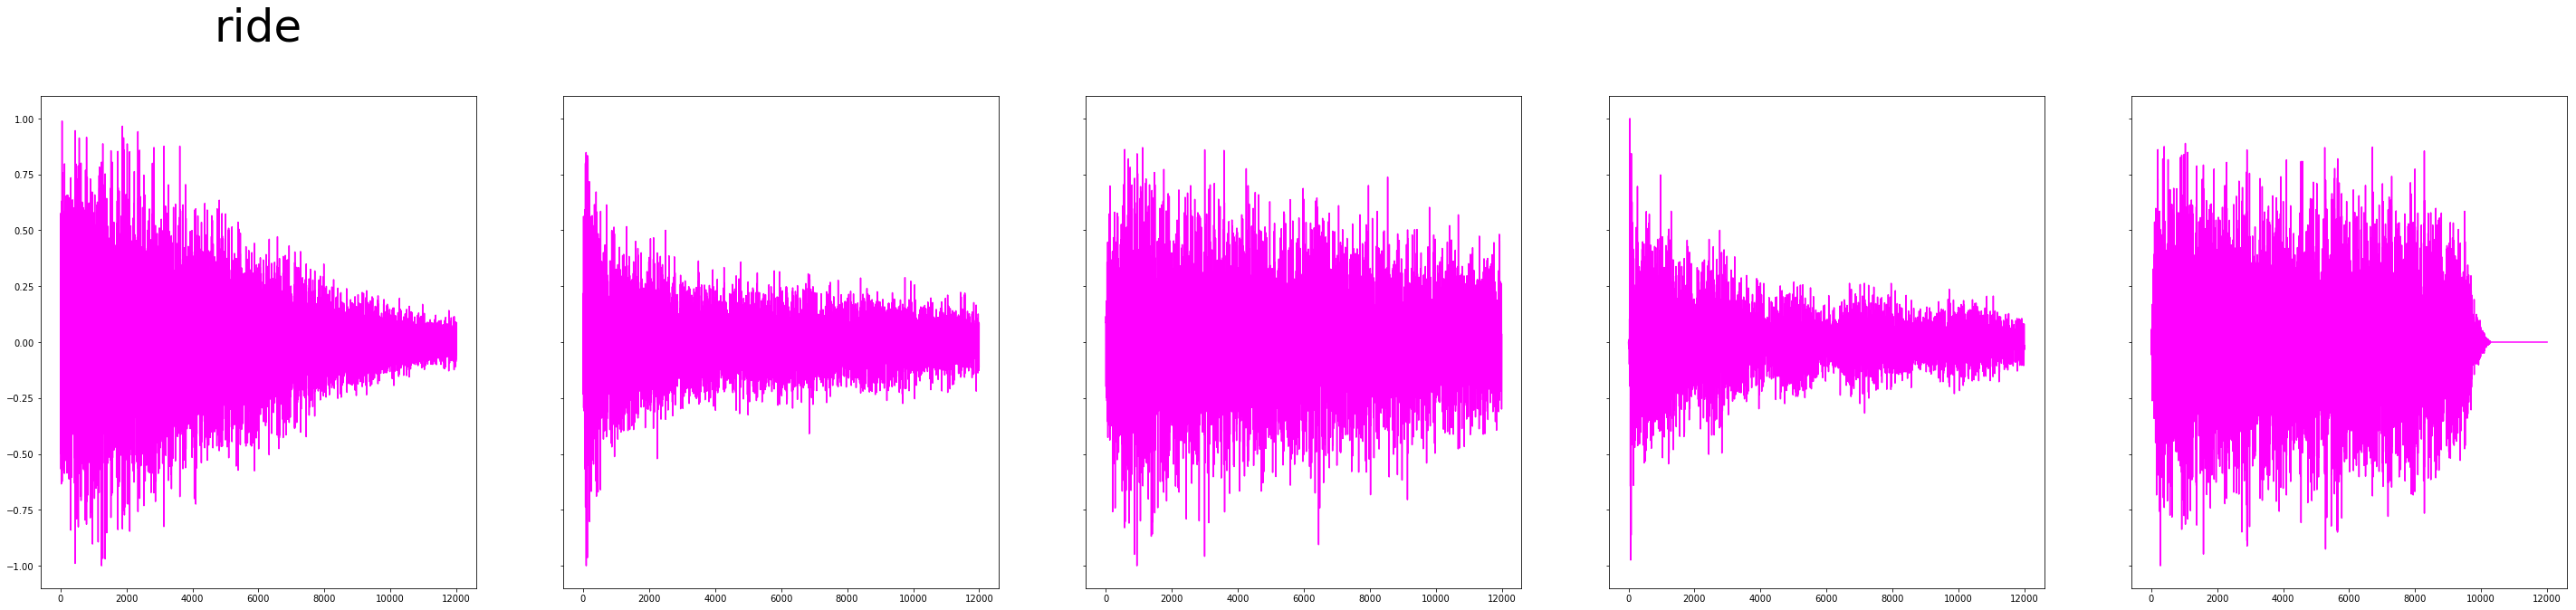

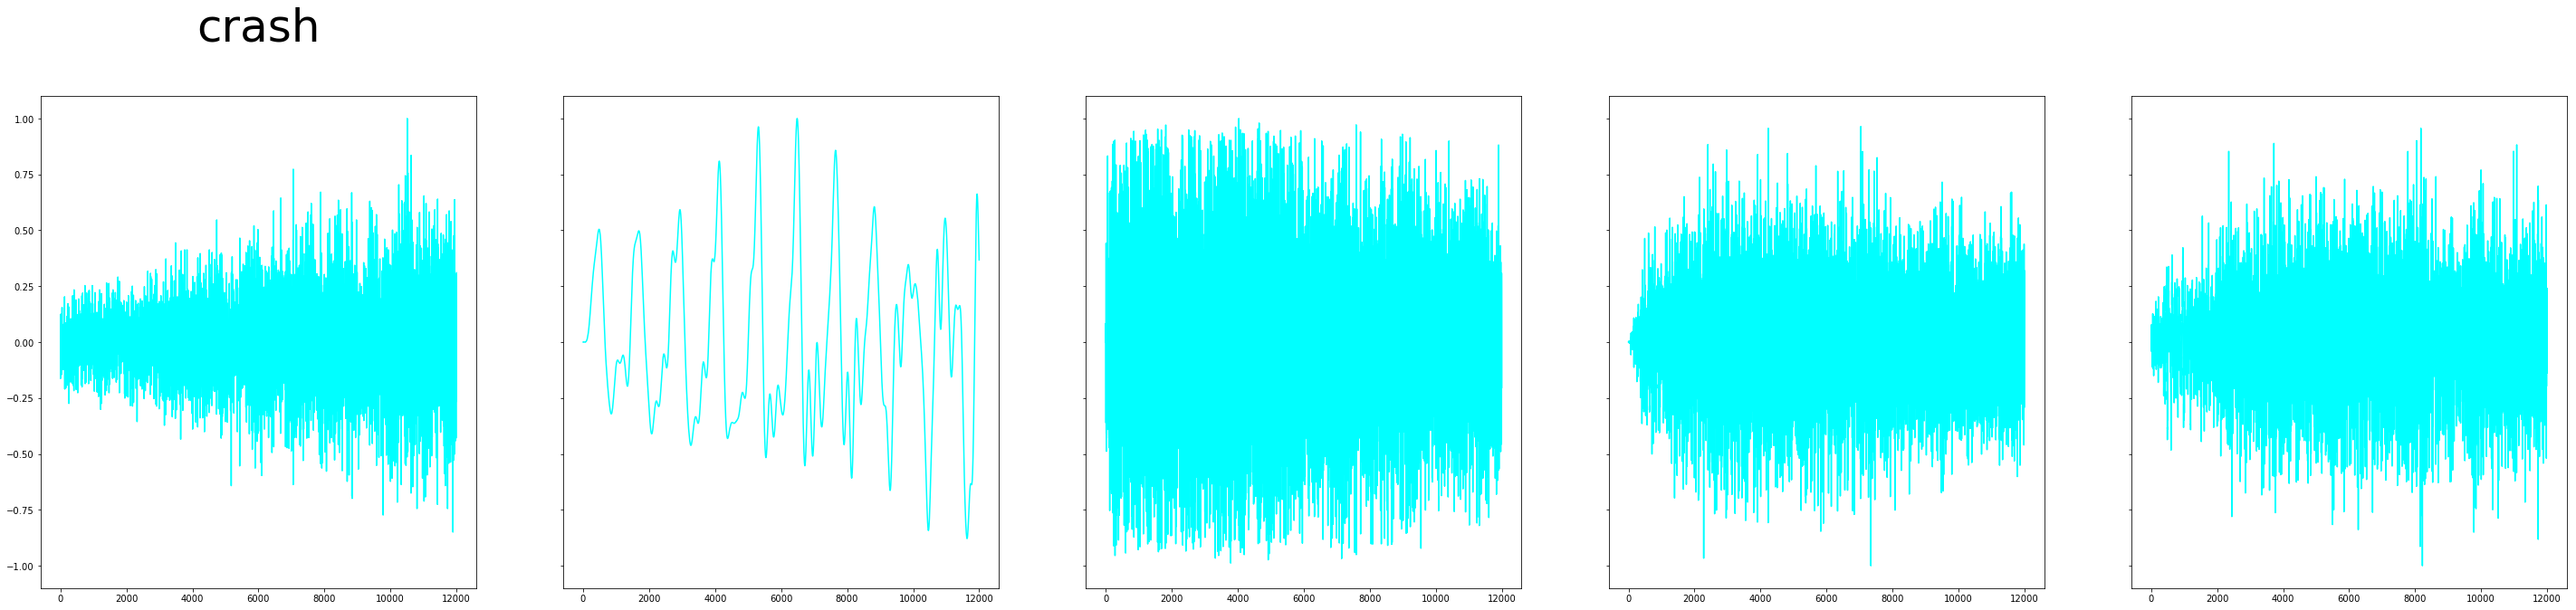

In [84]:
for drum_name, color in zip(drumNames,colors):
    plotDrumSamples(drumSamples, drum_name, color)

# Loading extracted features from these Samples

To look at our pipeline for extracting features from the samples defined above, look at the notebook "2. Extract Features from Sample". Here we have precomputed all the features and are simply loading them into the session. All features are saved as `.npy` files in `./drumFeatures`

In [117]:
def loadFeature(feature_name):
    drum_features = []
    for drum_name in drumNames: 
        file_path = './drumFeatures/' + drum_name + '_' + feature_name + '.npy'
        drum_feature = np.load(file_path)
        drum_features.extend(drum_feature)
    drum_features = np.asarray(drum_features)
    print(feature_name + " original dim", drum_features.shape)
    drum_features = drum_features.reshape(len(drum_features),-1)
    return drum_features

def loadAllFeatures(feature_dict):   
    x_data_features = {}
    for feature_name in feature_dict:
        print('-'*40)
        drum_features = loadFeature(feature_name)
        x_data_features[feature_name] = drum_features
    return x_data_features

Each of features have the following dimensionalities
    - stft = (N,32,32) 
    - mfcc = (N,30,24)
    - mir = (N,6,24)
    - wavenet = (N,23,16)

In [118]:
feature_list = ['stft','mfcc','mir','wavenet']
x_data_dict = loadAllFeatures(feature_list)

----------------------------------------
('stft original dim', (10560, 32, 32))
----------------------------------------
('mfcc original dim', (10560, 30, 24))
----------------------------------------
('mir original dim', (10560, 6, 24))
----------------------------------------
('wavenet original dim', (10560, 23, 16))


In order to do dimensionality reduction, we have to `flatten()` the matrices into one long feature vector.
    - stft = (N,1024) 
    - mfcc = (N,720)
    - mir = (N,144)
    - wavenet = (N,368)

In [119]:
for feature_name in feature_dict:
    print('-' * 40)
    print(feature_name + ".flatten() dim",x_data_dict[feature_name].shape)

----------------------------------------
('stft.flatten() dim', (10560, 1024))
----------------------------------------
('mfcc.flatten() dim', (10560, 720))
----------------------------------------
('mir.flatten() dim', (10560, 144))
----------------------------------------
('wavenet.flatten() dim', (10560, 368))


# Create the ground truth lables

The ground truth class labels are simply: 
    * 0 = kick
    * 1 = tom 
    * 2 = snare 
    * 3 = clap 
    * 4 = hi.hat 
    * 5 = ride
    * 6 = crash 

In [114]:
drumLabels = []
for i, drum_name in enumerate(drumNames):
    file_path = './drumFeatures/' + drum_name + '_' + 'stft' + '.npy'
    STFT_feat = np.load(file_path)
    drumLabels.extend([i] * STFT_feat.shape[0])
y_data_labels = np.asarray(drumLabels)

As a sanity check, we would expect the grouth truth labels to just make a series of "stairs" from 0 to 6 if we plotted it

('y_data_labels.shape:', (10560,))


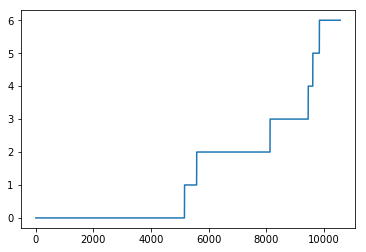

In [116]:
print("y_data_labels.shape:", y_data_labels.shape)
plt.figure()
plt.plot(y_data_labels)

# Create ground truth color map

We define an array to hold the colors of each sample. When we plot all the samples in 2D, we can go back and color in all the samples to visually see the quality of clustering.

In [121]:
import itertools
def concatColors(segmentList, colorList):
    multiples = []
    for i in range(len(segmentList)):
        multiples.append([colorList[i]]*segmentList[i])
    return list(itertools.chain(*multiples))

colors = ['#000000', '#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '#00ffff']
drumLengths = [5158,422,2546,1324,159,228,723]
colorMap = concatColors(drumLengths, colors)

# Metrics for evaluation

We define a 

# Evaluating PCA dimensionality reduction

We will use PCA to extract the 2 principal components and plot these.

In [ ]:
def plotPCA2D(data_X, data_Y, title):
    # #############################################################################
    # Visualize the results on PCA-reduced data
    np.random.seed(42)
    data = data_X

    n_samples, n_features = data.shape
    #n_digits = len(np.unique(digits.target))
    n_digits = 7
    labels = data_Y

    reduced_data = PCA(n_components=2).fit_transform(data)
    kmeans = KMeans(init='random', n_clusters=n_digits, n_init=10)
    kmeans.fit(reduced_data)
    
    #plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1],c=colorMap,s=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering on the drumset dataset (Top 2 PCA-reduced data)\n'
              'Centroids are marked with white cross\n' +
                title)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()
    
def computeSilCoeff(data, cluster_labels):
    redu_data = PCA(n_components=2).fit_transform(data)
    print("original data dim:", data.shape)
    print("reduced data dim:", redu_data.shape)
    silhouette_avg = silhouette_score(redu_data, cluster_labels)
    print("The average silhouette_score is :", silhouette_avg)